# **CSCI 4402	FINAL YEAR PROJECT II**


> # **Detection of Cone Cut Errors in Dental Bitewing Radiograph using CNN for Quality Assurance**

## Prepared by:  
**MOHAMED MOUBARAK MOHAMED MISBAHOU MKOUBOI (1820705)**\
**Umayma Ahhmed (1810704)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/dataset/train'
test_path = '/content/drive/MyDrive/dataset/test'
valid_path = '/content/drive/MyDrive/dataset/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,    
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


## Loading the Images

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 3530 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.


### Let’s take a look at some of the train set images that we obtained from the Data Augmentation

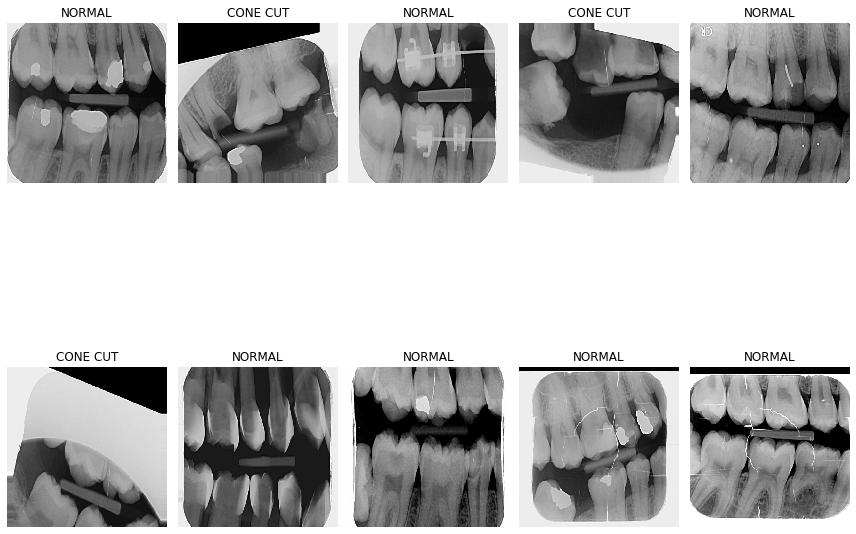

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'CONE CUT', 1:'NORMAL'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Convolutional Neural Network

In [ ]:
# Necessary imports
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

### Interpreting Model Summary

In [ ]:
# Hyperparameters of Conv2D
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(height,width,color,channel),
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )


NameError: ignored

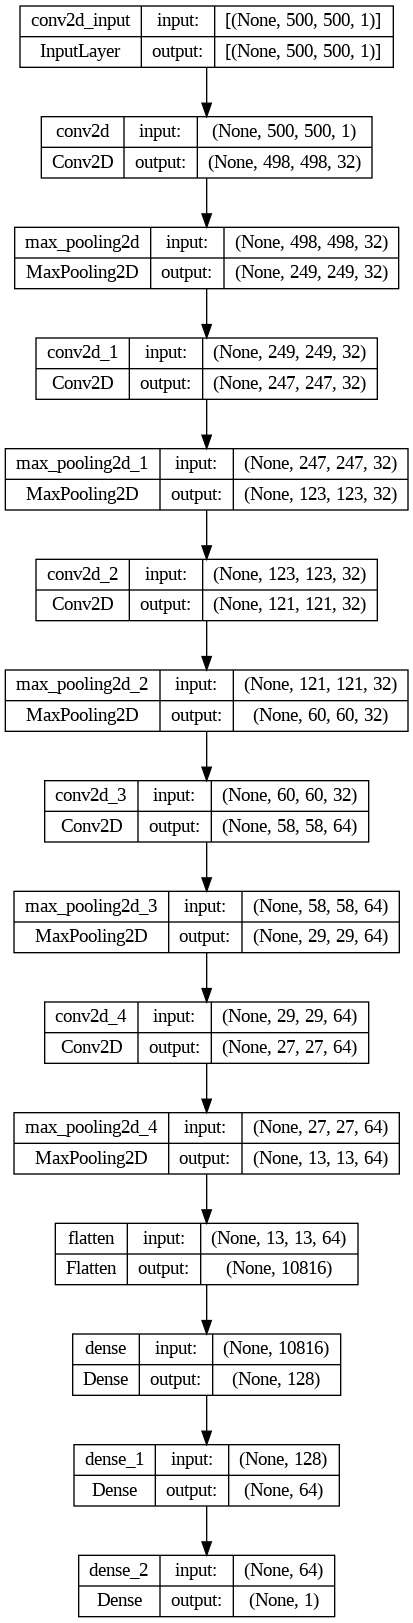

In [ ]:
# Visualize CNN model

from keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
# Defining Callback list

early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
# Assigning Class Weights

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0412979351032448, 1: 0.9618528610354223}


## Training

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
221/221 [==============================] - 743s 3s/step - loss: 0.3628 - accuracy: 0.8289 - val_loss: 0.1877 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 2/25
221/221 [==============================] - 255s 1s/step - loss: 0.1809 - accuracy: 0.9346 - val_loss: 0.1163 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/25
221/221 [==============================] - 240s 1s/step - loss: 0.1588 - accuracy: 0.9428 - val_loss: 0.1327 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 4/25
221/221 [==============================] - 238s 1s/step - loss: 0.1335 - accuracy: 0.9524 - val_loss: 0.0966 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 5/25
221/221 [==============================] - 238s 1s/step - loss: 0.1098 - accuracy: 0.9632 - val_loss: 0.0807 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 6/25
221/221 [==============================] - 236s 1s/step - loss: 0.1003 - accuracy: 0.9654 - val_loss: 0.0842 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 7/25
221/221 [==============================] - ETA: 0s - 

## Evaluate

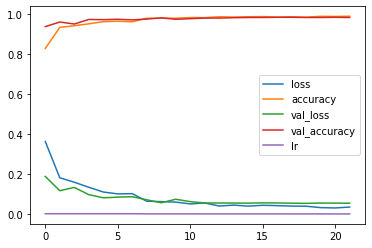

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
# Accuracy on test data

test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

32/32 [==============================] - 121s 4s/step - loss: 0.0410 - accuracy: 0.9862
The testing accuracy is : 98.6166000366211 %


In [ ]:
# Predict the test data

preds = cnn.predict(test,verbose=1)

32/32 [==============================] - 8s 233ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

## Confusion Matrix

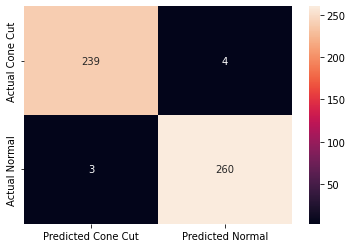

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Cone Cut", "Actual Normal"],
columns=["Predicted Cone Cut", "Predicted Normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
# Classification Report

print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['CONE CUT','NORMAL']))

              precision    recall  f1-score   support

    CONE CUT       0.99      0.98      0.99       243
      NORMAL       0.98      0.99      0.99       263

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



## Let’s visualize some of the predicted images with percentage %

(506, 500, 500, 1)
(506,)


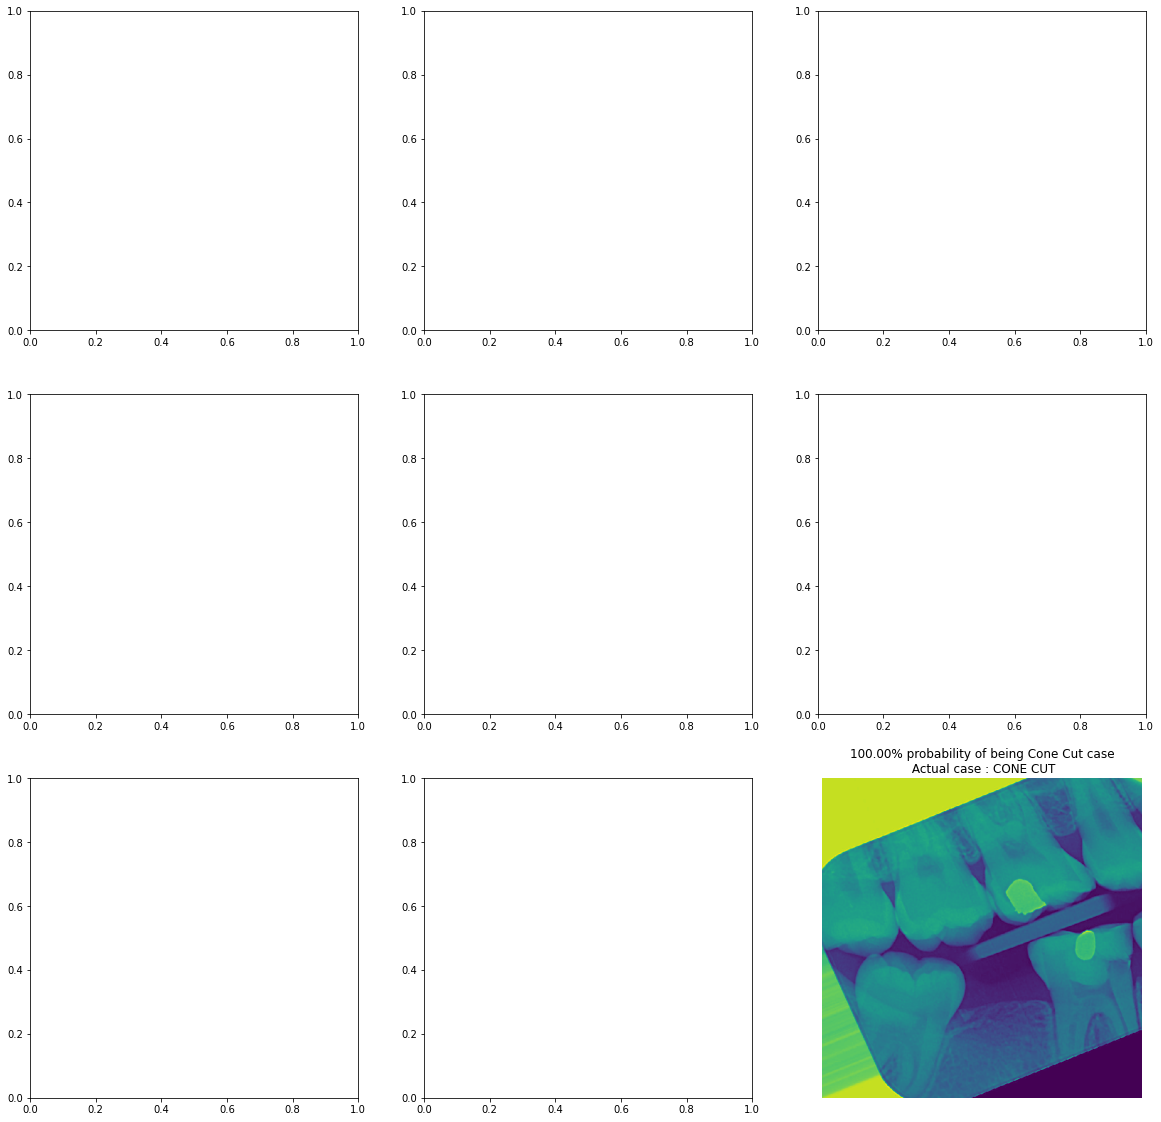

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'CONE CUT', 1:'NORMAL'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Normal case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Cone Cut case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

### Let’s do some field testing on our model with my X-ray

1/1 [==============================] - 0s 118ms/step


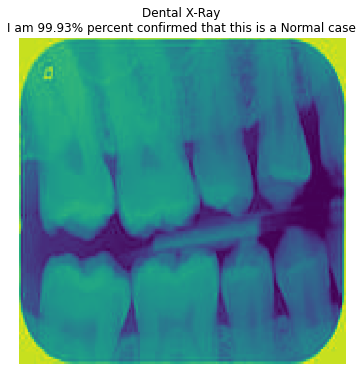

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/drive/MyDrive/dataset/download (1).jpeg'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Cone Cut case'.format(1-hardik_preds[0][0]))
plt.title("Dental X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

1/1 [==============================] - 0s 36ms/step


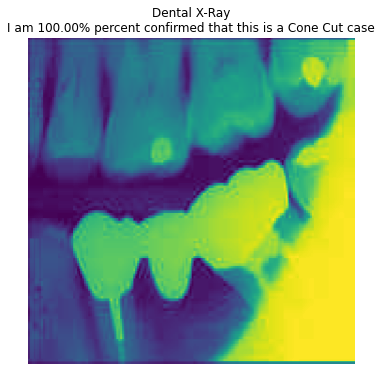

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/drive/MyDrive/dataset/download.jpeg'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Cone Cut case'.format(1-hardik_preds[0][0]))
plt.title("Dental X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

1/1 [==============================] - 0s 35ms/step


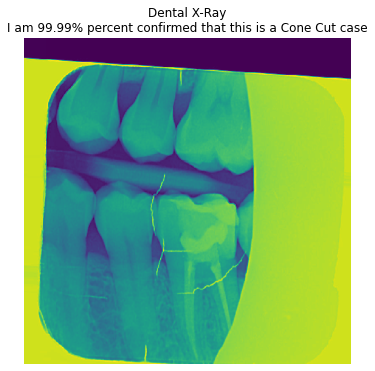

In [ ]:
# Testing with my own Chest X-Ray
hardik_path = '/content/drive/MyDrive/dataset/test/cone cut/cone cut 1005.jpg'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Cone Cut case'.format(1-hardik_preds[0][0]))
plt.title("Dental X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

# Save and load models

In [ ]:
!mkdir -p saved_model
cnn.save('saved_model/my_model') 

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
import tensorflow as tf

new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [ ]:
cnn.save('my_model.h5') 

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a